In [2]:
%load_ext autoreload
%autoreload 2

In [59]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from functions.hyperloglog import HashLogLog, HyperLogLog
from functions.clustering import KMeansClustering, elbow_method, plot_wordclouds, reviews_per_cluster, plot_distributions, uniqueusers_per_cluster, wordcloud_comparison, compare_clusters
from functions.data_preprocess import remove_html_tags, preprocess, tfidf_svd, lemmatization

# 1. Hashing

## Sequentially adding data to the HLL
## What is HyperLogLog?
The implementation of the HyperLogLog algorithm is based on the [paper](http://algo.inria.fr/flajolet/Publications/FlFuGaMe07.pdf) published by Flajolet et al. in 2007, where they present and explain a strategy to approximate the number of of distinct element in a multiset. In short, the basis of the HyperLogLog algorithm is the observation that the cardinality of a multiset of uniformly distributed random numbers can be estimated by calculating the maximum number of leading zeros in the binary representation of each number in the set. If the maximum number of leading zeros observed is $n$, an estimate for the number of distinct elements in the set is $2^n$. In order to obtain a uniformely distributed random numbers, the algorithm proposes to use a hash function on the original multiset.
## The hash function
As we just observed, we need use one hash function on the original set. We decided to implement a universal family of hashing functions, basing our rationale on the work by Carter et al. on the paper [Universal classes of hash functions](https://www.sciencedirect.com/science/article/pii/0022000079900448?via%3Dihub). In particular, we coded the hash function defined by the modulo operation. Let's give some details about it!

We randomly pick a hash function from a family of hashing functions
$$H = \{h: U \to [m]\}$$
that maps our universe $U$ to a set of dimension $m$. The hashing functions family we defined is, as we already said, the following:
$$h_{a, b}(x) = ((ax + b) \mod p) \mod m$$
where $p$ is a prime s.t. $p \ge m$ and $a$ and $b$ are randomly chosen integers s.t. $a \ne 0$ and both lower than $p$.

## Our choices
Once we have the hashing function, we need to choose the dimension of the arriving space for the hashing function and the number of bits used for the buckets in the HyperLogLog structure. We decided to use 32 bits for the hash and we tried two different combinations for the bucket lenght. First, we tried to use 6 bits for it, then we tried to improve our results by increasing this number to 11.

In [3]:
log2m = 6
bits = 32

HLL_6 = HyperLogLog(log2m=log2m, bits=bits)

hll_6 = HLL_6.structure('hash.txt')

print('HyperLogLog structure - list:')
print(hll_6)

HyperLogLog structure - list:
[23, 21, 23, 21, 23, 25, 22, 23, 23, 20, 21, 23, 21, 20, 22, 22, 21, 26, 20, 21, 26, 22, 21, 22, 22, 22, 20, 22, 25, 23, 26, 22, 24, 21, 21, 21, 21, 20, 20, 21, 24, 21, 24, 25, 22, 21, 25, 25, 25, 22, 20, 24, 22, 26, 20, 24, 24, 26, 21, 26, 20, 25, 22, 21]


## Cardinality and (relative) error of the filter

In [6]:
estimate_6 = HLL_6.cardinality(hll_6)
error_6 = HLL_6.error()

print('Total bits: {}'.format(bits))
print('Bits for the buckets: {}'.format(log2m))
print('Estimate: {}'.format(estimate_6))
print('Relative error: {:.3f}'.format(error_6))

Total bits: 32
Bits for the buckets: 11
Estimate: 139604896
Relative error: 0.130


### Observation
Maybe we can do a little bit better by increasing the lenght of the root to 11 bits. This seems to be a good point for the tradeoff between error and efficiency!

In [5]:
log2m = 11
bits = 32

HLL_11 = HyperLogLog(log2m=log2m, bits=bits)

hll_11 = HLL_11.structure('hash.txt')

estimate_11 = HLL_11.cardinality(hll_11)

error_11 = HLL_11.error()

print('Total bits: {}'.format(bits))
print('Bits for the buckets: {}'.format(log2m))
print('Estimate: {}'.format(estimate_11))
print('Relative error: {:.3f}'.format(error_11))

Total bits: 32
Bits for the buckets: 11
Estimate: 123189077
Relative error: 0.023


# Real error
The error we showed before is just a relative metric we can compute using the values we are feeding the HyperLogLog structure. We based our calculations, again, on the theory on the Flajolet paper. This metric they give is defined by $\frac{1.04}{\sqrt(m)}$.

To compute the real error of the algorithm we used, we have to count the exact number of unique elements that appear in the `hash.txt` file. In order to do that, there are severel options. One of those is to use shell commands, and that's what we've chosen to do.

In [5]:
!sort hash.txt | uniq | wc -l

125000000


Now that we know the exact number of unique elements in the `hash.txt` file, we can compute the actual error we made. Considering the estimation made using 11 bits for the buckets, we have an error of:

# 2. Clustering

## Preprocess data
The first step we need to take in order to apply any clustering model (any model, actually) to data is preprocessing. There are several important things we are going to do in this section, so let's sketch them out.

The first (mandatory) step we needed to perform on the data was to **clean** it a little bit, removing html tags, punctuation, and lowering all the `Text` column. Once we did that, we decide (a posteriori) to perform two extra steps, which were:

1. Remove **non-nouns words** from the text;
2. Create a custom **domain-specific set of stopwords** to clean the data.

Let's analyze both these points singularly
- The rationale behind the first point is that the goal of this preprocess is to actually have a clustering as much as possible close to what we would imagine, which is to divide the reviews made by the users based on the item they're reviewing. Verbs, adjectives, and adverbs don't really matter in this scenario. To be honest, we actually first tried to work with everything we had in our hands, but the results weren't satisfying. In fact, even if we used tfidf and svd, the data seemed to be in the largest part made by noise. We initially tried to perform this step after the clustering, and even if the results were somehow ok, we felt like there wasn't a real way to interpret the model results. Yep, there was probably a rationale behind the clusters, but the interpretability wasn't there. Interpretability in machine learning is not an easy task, but we felt like, at least for a simple model like KMeans, we could have done better. And we did!
- Domain-specific stopwords can be a very strong (and boring) tool to deal with this kind of task. Obviously, this can't be the key to the success of our model, since we are dealing with really high dimensional spaces, but it certainly can make a difference. To be more precise, we didn't only consider the domain we are working with (food ecommerce, reviews, etc.), but also the task we were asked to complete. In fact, some of the words we removed could be really useful in other situations, but we decided to build this domain-specific and task-specific set in order to tackle the questions we were asked: what kind of patterns we can find in the items people reviews?

The final preprocessing step was to **lemmatize** the text data, which is actually a standard step in the preprocessing pipeline.

### Data cleaning

In [485]:
data_path = './data/Reviews.csv'

data = pd.read_csv(data_path, index_col=False)

In [506]:
# Preprocess data
data['Text'] = data['Text'].apply(preprocess)
data['Text'] = data['Text'].apply(keep_nouns)
data['LemmatizedText'] = data['Text'].apply(lemmatization)
data = data[data['Text'] != '']

data = data.reset_index().drop(columns={'index', 'Id'})
data.to_csv('./data/clean_data.csv')

### Tf-idf representation and dimensionality reduction
Now we need to prepare the data for the actual clustering. There is a small problem, it is not that easy to deal with textual data. Well, there are plenty of solutions, but, probably, one of the simple ones is to just represent data with tfidf, a numerical representation of the data based on the term frequency and the inverse document frequency. We are not going to give more details on the tfidf representation, since we described it in full details during the previous homework!

Unfortunately, tfidf is not that easy to use either. Let's give a brief explanation: when we convert our textual data to its tfidf representation, what happens is that the algorithm creates very big vectors for each document. Each vector, contains exactly the number of distinct words in the entire corpus of documents as columns, each one representing the tfidf value of that particular word in the document represented by the row. This space is for obvious reasons really big (consider that we are dealing with ~576k documents in total), and for the most part each of the row is going to contain zeros almost everywhere. The reason why the vast majority of the components are going to be zeros is that a single document is only going to contain a (very) small portion of the corpus vocabulary, thus the term frequency of the words that don't appear in the document is going to be zero. The result is going to be that we are going to waste a lot of space with zeros! Luckily for us, sklearn automatically uses sparse data structures to handle this kind of problem, but once we try to perform any transformation on the data, we will have to load that data in ram, which is practically impossible.

To avoid this problem, we can perform some serious dimensionality reduction. SVD is the way to go! But, we need to be cautious. We don't want to remove useful information from our data, and for this reason we are going to select the number of components for the SVD algorithm such that we are able to retain at least 60% of variance in the data. The resulting number of components is 17.

In [4]:
data = pd.read_csv('./data/clean_data.csv', index_col=False)

In [5]:
data_reduced = tfidf_svd(data['LemmatizedText'])
data_reduced.shape

(566411, 17)

## Performing clustering

### Elbow method and KMeans clustering
Now we are ready to perform clustering on the data. Ok, but how many clusters are we expecting to find in our data? Well, that's not an easy question, and it's not something you already know beforehand. For this reason, we can exploit one interesting technique, the elbow method, which gives us a hint on the number of clusters we use.

Obviously, when choosing the number of clusters, we need to keep in mind that there is a tradeoff going on. The more clusters we select, the less error we get. At the same time, having a small error doesn't mean we have a better clusterization of the data, in fact we could lose generalization and our data could be splitted in too many groups. On the contrary, if we choose a really small number of clusters, we could end up having really different items in the same cluster.

The elbow method basically brute-forces this for us, trying different values for the cluster numbers. Once we see that the slope of the error curve starts to be really low (forming the elbow shape, from which the method takes the name), we can deduce that in that particular point there is a sweet spot between number of clusters (i.e., generalization of the algorithm) and error.

In this particular case, we tried 19 different combinations for the number of clusters, going from 2 to 20, and we found out that the best combination was (at least in our opinion) to select 16 clusters.

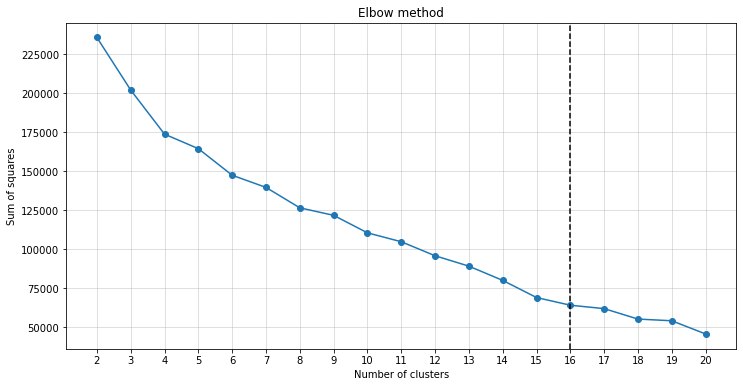

In [30]:
elbow_method(data_reduced, max_cluster_n=20)

In [6]:
n_clusters = 16
model = KMeansClustering(n_clusters=n_clusters)
cluster_labels = model.fit_predict(data_reduced)

data['Cluster'] = cluster_labels

### Wordcloud representation of the clusters
What do our clusters represent? This is a very important question. Wordclouds are a very standard way of showing results: they're cheap, and the results are easy to visualize. In our case, we decided to apply some simple tweek to the standard wordclouds. First of all, the data we are visualizing is the one we obtained after the first steps of the preprocess, but without the lemmatization. We decided to move in that direction so that the words we see have an actual meaning, something that rarely happens when we eradicate the tail applying lemmatization.

Then, we used, once again, tfidf to generate the wordclouds. Standard wordclouds are generated using the frequency of the terms in a certain corpus; on the other hand, we decided to sort the importance of the words by their term frequency and inverse document frequency in a given cluster.

We are quite happy with the results! Obviously, not all the clusters are that informative, there are unlucky ones that don't really make sense. But the vast majority of them give a good result. We can easily see that there is a different pattern in each of the cluster visualized. For example, the first cluster probably represent items related somehow to coffee; the items in the second cluster probably represent sweet snacks like chocolate and the third one clearly represent dog food, treats and so on.

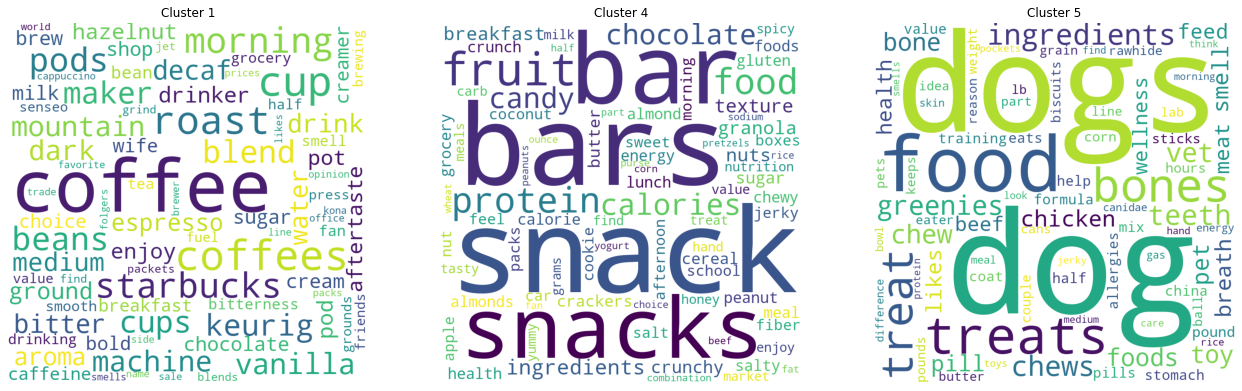

In [14]:
plot_wordclouds(data, clusters=[1, 4, 5])

## Algorithms comparison
In this section, we are going to check wether our algorithm is performing similarly to the sklearn one or not. There is one main difference we noticed, which is efficiency. Even if we tried to optimize our code in every way, removing for loops and vectorizing the code when possible, it seems like our algorithm is still much slower than the one by sklearn. Analyzing the code in the sklearn library, we think there are probably multiple reasons why this happens. First of all, they implemented several stopping criterias, such that the algorithm is going to stop even without meeting very strict conditions, still retaining a really good score/error. More over, there is probably some batch implementation going on, making the algorithm much faster.

Performance apart, is our algorithm different from the sklearn one? Well, it's not easy to say. But we can try to check something. First, let's run the algorithm.

In [7]:
model = KMeans(n_clusters=n_clusters)
cluster_labels = model.fit_predict(data_reduced)

data['Cluster_sklearn'] = cluster_labels

One interesting thing is to actually compare clusters made by one and another algorithm with wordcloud. In order to do that, we select, from each algorithm-clusters, the clusters based on their dimensions. This means that if we choose to compare cluster number 2, we are going to compare cluster number two for our custom kmeans algorithm with the cluster most similar in dimension with that one. For this particular example, it seems like our algorithm and the sklearn one actually work in a really similar way, which is good!

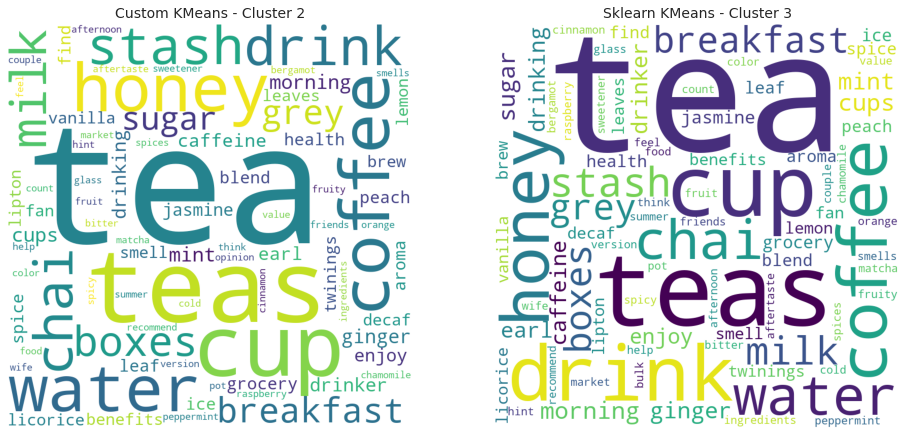

In [377]:
wordcloud_comparison(data, cluster=2)

Another possible approach, probably more strict than the previous one, is to actually check the differences between the clusters computed by one or another algorithm, checking the documents contained in both of them. This is not something it's always possible to do, since, sometime, we just cannot see which cluster of the first algorithm corresponds to one of the second algorithm. However, we can start by comparing the biggest clusters created by both the algorithm, which seem to be about the same size! Let's find which ones are they, first.

In [29]:
biggest_custom = reviews_per_cluster(data).sort_values(by='Reviews Number', ascending=False).iloc[0]['Cluster']
biggest_sklearn = reviews_per_cluster(data, cluster_col='Cluster_sklearn').sort_values(by='Reviews Number', ascending=False).iloc[0]['Cluster_sklearn']

print('Biggest cluster created by custom K-Means: \t{}\n'
      'Biggest cluster created by Sklearn K-Means: \t{}'.format(biggest_custom, biggest_sklearn))

Biggest cluster created by custom K-Means: 	0
Biggest cluster created by Sklearn K-Means: 	1


Now we can check the percentage of documents that are actually clustered in the same way by both the algorithm, using an "and" query. In a more formal way, we can check what's the value for both these percentages:
$$P_1 = \frac{custom(0) \text{ and } sklearn(1)}{custom(0)} \qquad \qquad P_2 = \frac{custom(0) \text{ and } sklearn(1)}{sklearn(1)}$$

In [76]:
num = data[(data['Cluster'] == biggest_custom) & (data['Cluster_sklearn'] == biggest_sklearn)].shape[0]
den_1 = data[data['Cluster'] == biggest_custom].shape[0]
den_2 = data[data['Cluster_sklearn'] == biggest_sklearn].shape[0]
prob_1 = num / den_1
prob_2 = num / den_2

print('P1 = {:.3f}\n'
      'P2 = {:.3f}'.format(prob_1, prob_2))

P1 = 0.974
P2 = 0.922


And this tells us that the two cluster are actually really similar, which we expected in a naive way seeing the two wordclouds. We decided to go full details for this operation, also showing the code, since it may be clearer what we were aiming to do. It should be clear now, so let's just use some function to do the exact same thing with other clusters. First of all, for a given custom cluster (generated by custom K-Means), `compare_clusters()` is going to search for the most suitable candidate among the sklearn clusters, by looking at their sizes. Then, it's going to do the exact same thing we did for the first one.

As we can see on the following cell, the the probability is often high. There is some outlier, but we are pretty confident that searching more accurately between the "wrong" pairs would result in a nearly optimal intersection in all cases.

In [82]:
for cl_n in range(n_clusters):
    print('Custom cluster {} - Sklearn cluster {}\n'
          'P1 = {:.3f}\n'
          'P2 = {:.3f}'.format(cl_n, *compare_clusters(data, cl_n)))
    print('-'*27)

Custom cluster 0 - Sklearn cluster 1
P1 = 0.974
P2 = 0.922
---------------------------
Custom cluster 1 - Sklearn cluster 8
P1 = 1.000
P2 = 0.984
---------------------------
Custom cluster 2 - Sklearn cluster 2
P1 = 0.999
P2 = 0.964
---------------------------
Custom cluster 3 - Sklearn cluster 2
P1 = 0.000
P2 = 0.000
---------------------------
Custom cluster 4 - Sklearn cluster 3
P1 = 0.001
P2 = 0.001
---------------------------
Custom cluster 5 - Sklearn cluster 7
P1 = 0.974
P2 = 0.986
---------------------------
Custom cluster 6 - Sklearn cluster 5
P1 = 0.000
P2 = 0.000
---------------------------
Custom cluster 7 - Sklearn cluster 5
P1 = 0.997
P2 = 0.978
---------------------------
Custom cluster 8 - Sklearn cluster 10
P1 = 0.001
P2 = 0.001
---------------------------
Custom cluster 9 - Sklearn cluster 11
P1 = 0.000
P2 = 0.000
---------------------------
Custom cluster 10 - Sklearn cluster 0
P1 = 0.995
P2 = 0.996
---------------------------
Custom cluster 11 - Sklearn cluster 9
P1

### Number of elements in each cluster
There isn't really much to say about this. This is just the number of reviewed elements in each cluster. Notice that we sorted the clusters given by the kmeans algorithm such that the first cluster is the most populated one, and the last one such that it is the least populated. Then, it goes in a orderly fashion.

Obviously, not all the clusters have the same dimension! This is logic and right, in our perspective. In fact, there are probably set of items that are much more reviewed than others, so that makes perfect sense.

In [37]:
reviews_per_cluster(data)

,Cluster,Reviews Number
0,0,222236
1,1,45688
2,2,39314
3,3,38920
4,4,29533
5,5,26304
6,6,21726
7,7,20460
8,8,18685
9,9,17056


### Distribution of the score for each cluster
The following plots are self explanatory: there isn't really that much of a change between each cluster in terms of score values. In fact, we can observe that all the clusters have the same behaviour: the vast majority of the users give a full score to the products they review; then, a great part of the remaining reviews have a 4 stars score. Finally, the last remaining part is almost equally distributed among the remaining scores: 1, 2 and 3 stars.

This kind of pattern is also observable from the mean and standard deviation of the cluster score distribution. In fact, we can see that the mean value is always around 4 stars, and the standard deviation never exceed 1.4.

There are probably two explanations for this behaviour: the first one is that users, most of the time, don't really bother in reviewing a product unless they're really happy. Moreover, it is much easier to just say that the product "is good", compared to give an actual score to it (i.e., why bother in selecting a score if you can just say: "5 stars, good; 1 star, not good"?).

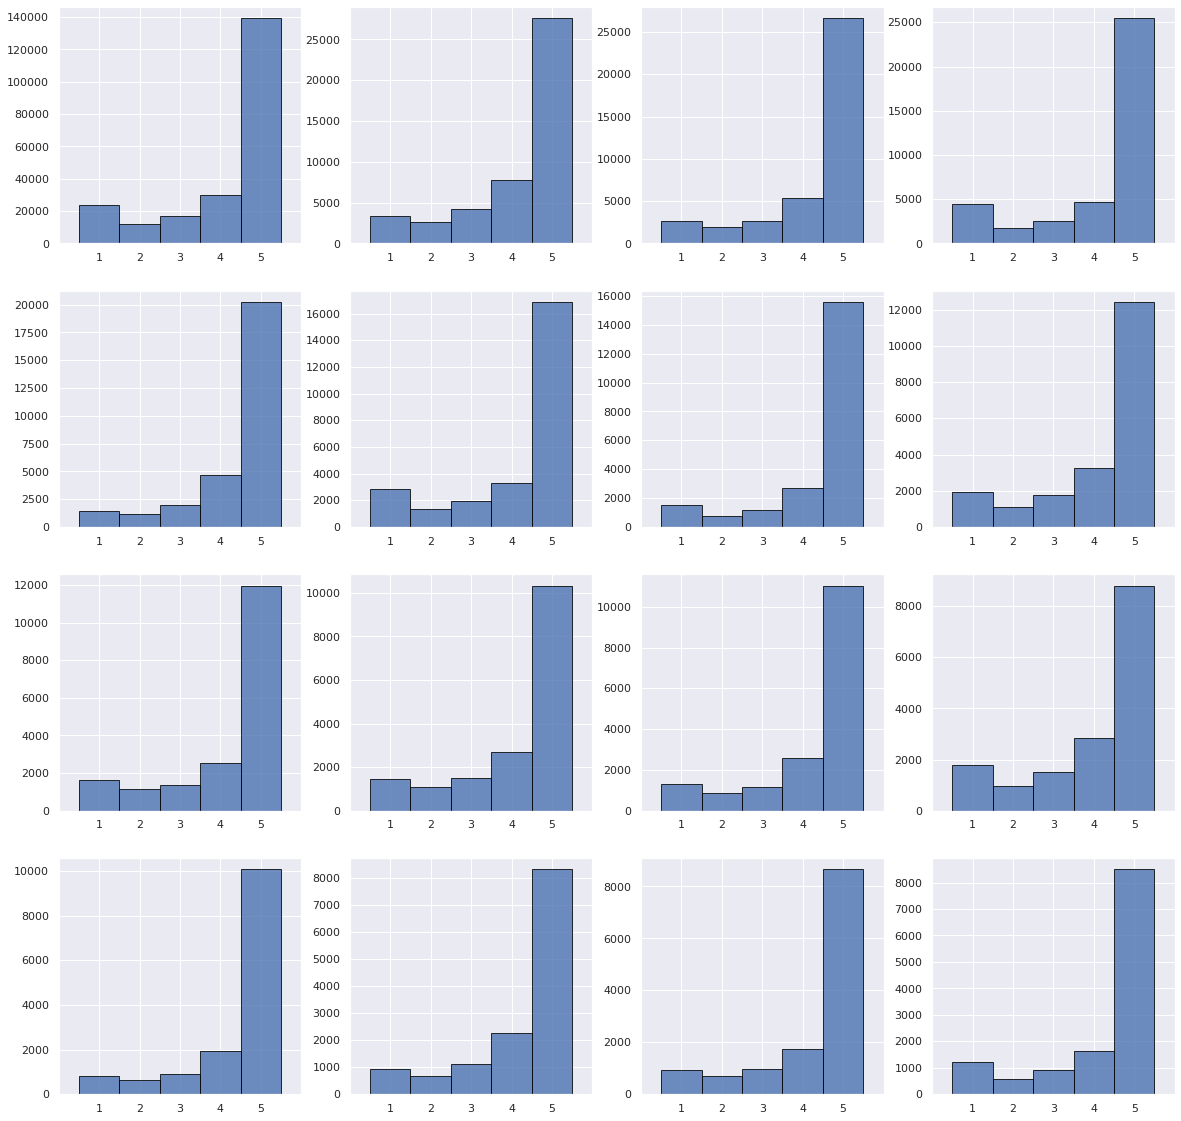

In [378]:
plot_distributions(data)

In [379]:
data.groupby('Cluster').agg({'Score':['mean','std']})

Score          
             mean       std
Cluster                    
0        4.119495  1.368070
1        4.171424  1.253266
2        4.309483  1.203522
3        4.152852  1.382124
4        4.393255  1.092572
5        4.143020  1.366775
6        4.381202  1.183603
7        4.133480  1.315265
8        4.182553  1.308502
9        4.136257  1.302442
10       4.252807  1.245961
11       3.999937  1.378487
12       4.375434  1.148178
13       4.224291  1.227204
14       4.265992  1.238262
15       4.212999  1.312503

### Unique users per cluster
In this last part of this exercise, we analyze the number of unique users in a given cluster. Again, it makes perfect sense that this number is not constant throughout all the clusters; once again, it is possible that a cluster is much more rewiewed than another, and that some particular users reviews much more elements in a given set of items.

In [380]:
uniqueusers_per_cluster(data)

,Cluster,UserId
0,0,134003
1,1,23526
2,2,21237
3,3,19629
4,4,15109
5,5,12045
6,6,9962
7,7,9669
8,8,12139
9,9,11490


# Algorithmic question
For this particular question, we are asked to prove that we can sort an array of integers in time $O(n + r)$, where $n$ is the lenght of the array and $r$ is the difference between the max and the min of the array.

First of all, we implemented the algorithm itself. This algorithm is the [Counting Sort](https://en.wikipedia.org/wiki/Counting_sort). We also wrote the time complexity for each of the operation used on the algorithm, so that it's really easy to compute its total asymptotic complexity.

In [38]:
def counting_sort(arr):
    max_ = max(arr)                 # O(n)
    min_ = min(arr)                 # O(n)

    s = max_+ 1 - min_              # O(1)

    index_array = [0]*(s)           # O(s)

    for i in arr:                   # O(s)
        index_array[i - min_] += 1  # O(1)

    output = list()                 # O(1)

    c = min_                        # O(1)
    for i in index_array:           # O(s)
        for m in range(i):          # O(n)
            output.append(c)        # O(s)
        c = c + 1                   # O(s)

    return output                   # O(1)